In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from shapely.geometry import Polygon, Point, LineString
import time

In [ ]:
# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

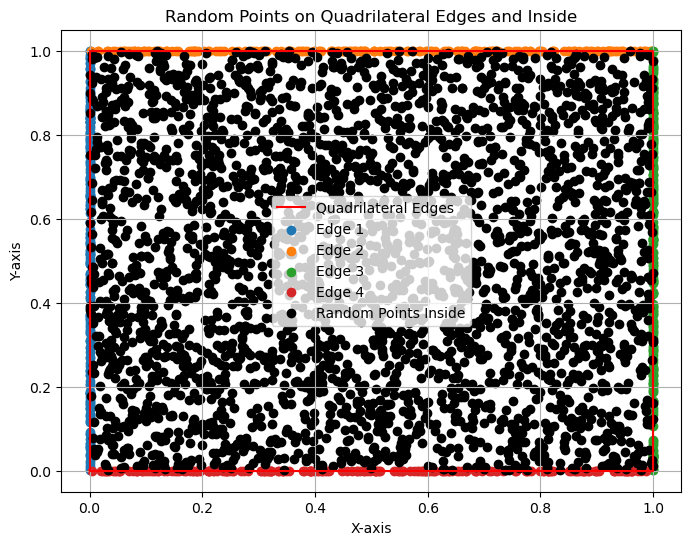

In [ ]:
# Define the four corner points of the quadrilateral
points = [(0, 0), (0, 1), (1, 1), (1, 0)]

# Create a Shapely polygon from the points
polygon = Polygon(points)

# Initialize lists to store random points on each edge
bound_pts = [[] for _ in range(len(points))]

# Generate random points on each line segment of the polygon (edges)
num_points_per_edge = 200 # Number of random points to generate on each edge

for i in range(len(points)):
    p1 = points[i]
    p2 = points[(i + 1) % len(points)]  # Wrap around to the first point after the last one

    line = LineString([p1, p2])
    length = line.length

    for _ in range(num_points_per_edge):
        # Generate a random distance along the line segment
        random_distance = np.random.uniform(0, length)
        random_point = line.interpolate(random_distance)
        bound_pts[i].append([random_point.x, random_point.y])

# Generate random points inside the polygon using a bounding box
num_points_inside = 3000  # Number of random points inside the polygon
min_x, min_y, max_x, max_y = polygon.bounds
coloc_pts = []

while len(coloc_pts) < num_points_inside:
    x = np.random.uniform(min_x, max_x)
    y = np.random.uniform(min_y, max_y)
    point = Point(x, y)
    if polygon.contains(point):
        coloc_pts.append([x, y])

# Convert the lists of random points on each edge and inside to NumPy arrays
bound_pts = [np.array(edge_points) for edge_points in bound_pts]
coloc_pts = np.array(coloc_pts)

############################################# Plotting the points and lines #####################################################

plt.figure(figsize=(8, 6))

# Plotting lines connecting the corner points of the quadrilateral
edges = np.array(points + [points[0]])
plt.plot(edges[:, 0], edges[:, 1], 'r-', label='Quadrilateral Edges')

# Plotting random points on each edge separately
for i, edge_points in enumerate(bound_pts):
    edge_points = np.array(edge_points)
    plt.scatter(edge_points[:, 0], edge_points[:, 1], label=f'Edge {i+1}')

# Plotting random points inside the quadrilateral
plt.scatter(coloc_pts[:, 0], coloc_pts[:, 1], color='black', label='Random Points Inside')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Random Points on Quadrilateral Edges and Inside')
plt.legend()
plt.grid(True)
plt.show()

#coloc_pts
#bound_pts


In [ ]:
T_l = 700
T_r = 350
T_u = 350
T_b = 350
k = 238
q=1000000.00



In [ ]:
coloc_pts = torch.from_numpy(coloc_pts.astype(np.float32)).to(device)

In [ ]:
# Convert NumPy array to float32 and then to a PyTorch tensor
bound_pts = [torch.tensor(arr, dtype=torch.float32) for arr in bound_pts]


In [ ]:
data_l = bound_pts[0]
data_u = bound_pts[1]
data_r = bound_pts[2]
data_b = bound_pts[3]

# Move tensors to CUDA if available
data_l = data_l.to('cuda')
data_u = data_u.to('cuda')
data_r = data_r.to('cuda')
data_b = data_b.to('cuda')

In [ ]:
class PINN2D(nn.Module):
    def __init__(self):
        super(PINN2D, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 21),  # 2 input neurons for (x, y)
            nn.Tanh(),

            nn.Linear(21, 21),
            nn.Tanh(),


            nn.Linear(21, 1)
        )

    def forward(self, xy):
        return self.layers(xy)


In [ ]:
def pde_loss_2d(model_2d, coloc_pts):
    coloc_pts.requires_grad = True
    T = model_2d(coloc_pts)

    # Compute the second derivatives
    T_x = torch.autograd.grad(T, coloc_pts, torch.ones_like(T), create_graph=True, retain_graph=True)[0][:, 0]
    T_xx = torch.autograd.grad(T_x, coloc_pts, torch.ones_like(T_x), create_graph=True)[0][:, 0]

    T_y = torch.autograd.grad(T, coloc_pts, torch.ones_like(T), create_graph=True, retain_graph=True)[0][:, 1]
    T_yy = torch.autograd.grad(T_y, coloc_pts, torch.ones_like(T_y), create_graph=True)[0][:, 1]

    # Calculate the PDE loss term using your specific PDE equation
    pde_term = (T_xx + T_yy)+(q/k)   # Modify this according to your specific PDE

    # Compute the loss
    loss = torch.mean(torch.square(pde_term))

    return loss



# Proceed with your loss calculations using these boundary values
def left_boundary_loss(model):

    left_boundary_loss = torch.mean(torch.square(T_l - model(data_l)))
    return left_boundary_loss

def upper_boundary_loss(model):

    upper_boundary_loss = torch.mean(torch.square(T_u - model(data_u)))
    return upper_boundary_loss

def right_boundary_loss(model):

    right_boundary_loss = torch.mean(torch.square(T_r - model(data_r)))
    return right_boundary_loss

def bottom_boundary_loss(model):

    bottom_boundary_loss = torch.mean(torch.square(T_b - model(data_b)))
    return bottom_boundary_loss



In [ ]:
from torch.optim.lr_scheduler import StepLR

model_2d = PINN2D().to(device)
optimizer_2d = torch.optim.Adam(model_2d.parameters(), lr=0.001)
# Define the scheduler
scheduler = StepLR(optimizer_2d, step_size=50000, gamma=0.95)  # You can adjust step_size and gamma values

# Batching parameters
batch_size = 100  # Define your desired batch size

# Training loop with batching
epochs = 20
for epoch in range(epochs):
    # Shuffle coloc_pts to create different batches in each epoch
    np.random.shuffle(coloc_pts)

    for i in range(0, len(coloc_pts), batch_size):
        batch_pts = coloc_pts[i:i + batch_size]
        
        # Forward pass
        T = model_2d(batch_pts)

        # Compute losses
        p_l = pde_loss_2d(model_2d, batch_pts)
        l_l = left_boundary_loss(model_2d, data_r)
        r_l = right_boundary_loss(model_2d, data_r)
        b_l = bottom_boundary_loss(model_2d, data_b)
        u_l = upper_boundary_loss(model_2d, data_u)

        # Total loss
        total_loss = 0.1 * p_l + 0.9 * l_l + 0.9 * r_l + 0.9 * b_l + 0.9 * u_l

        optimizer_2d.zero_grad()
        total_loss.backward()
        optimizer_2d.step()

        # Print the loss after every few epochs
    if epoch % 1 == 0:
        print(f'Epoch: {epoch}, Total Loss: {total_loss.item()}, PDE Loss: {p_l.item()}, Left Loss: {l_l.item()}, Right Loss: {r_l.item()}, Bottom Loss: {b_l.item()}, Upper Loss: {u_l.item()}')
        print()


In [ ]:
s = time.time()
# Training loop
epochs = 200000 # You can adjust the number of epochs
for epoch in range(epochs):

    # Forward pass
    T = model_2d(coloc_pts)

    # Compute losses
    p_l = pde_loss_2d(model_2d, coloc_pts)
    l_l = left_boundary_loss(model_2d)
    r_l = right_boundary_loss(model_2d)
    b_l = bottom_boundary_loss(model_2d)
    u_l = upper_boundary_loss(model_2d)

    total_loss =   0.1 * p_l + l_l +  r_l + b_l + u_l

    optimizer_2d.zero_grad()
    total_loss.backward()
    optimizer_2d.step()

    # Learning rate scheduling
    scheduler.step()

    # Print the loss after every few epochs
    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}, Total Loss: {total_loss.item()}, PDE Loss: {p_l.item()}, Left Loss: {l_l.item()}, Right Loss: {r_l.item()}, Bottom Loss: {b_l.item()}, Upper Loss: {u_l.item()}')
        #print(p,u,b)
e = time.time()

Epoch: 0, Total Loss: 2623517.0, PDE Loss: 17655052.0, Left Loss: 490217.03125, Right Loss: 122590.6953125, Bottom Loss: 122619.59375, Upper Loss: 122584.59375
Epoch: 10000, Total Loss: 794942.3125, PDE Loss: 2290656.75, Left Loss: 323464.625, Right Loss: 67669.125, Bottom Loss: 103275.546875, Upper Loss: 71467.2890625
Epoch: 20000, Total Loss: 300139.375, PDE Loss: 740880.1875, Left Loss: 131535.109375, Right Loss: 24394.544921875, Bottom Loss: 39916.08984375, Upper Loss: 30205.6171875
Epoch: 30000, Total Loss: 65910.5390625, PDE Loss: 153492.25, Left Loss: 30953.64453125, Right Loss: 3066.93310546875, Bottom Loss: 7967.0009765625, Upper Loss: 8573.7353515625
Epoch: 40000, Total Loss: 5105.30126953125, PDE Loss: 8381.8359375, Left Loss: 2390.418701171875, Right Loss: 68.26943969726562, Bottom Loss: 689.5313110351562, Upper Loss: 1118.8980712890625
Epoch: 50000, Total Loss: 3437.62158203125, PDE Loss: 3662.084228515625, Left Loss: 1715.44580078125, Right Loss: 47.66932678222656, Bottom

KeyboardInterrupt: 

In [ ]:
print(f'Epoch: {epoch}, Total Loss: {total_loss.item()}, PDE Loss: {p_l.item()}, Left Loss: {l_l.item()}, Right Loss: {r_l.item()}, Bottom Loss: {b_l.item()}, Upper Loss: {u_l.item()}')


Epoch: 66591, Total Loss: 2918.04443359375, PDE Loss: 3164.958251953125, Left Loss: 1431.9771728515625, Right Loss: 32.1009407043457, Bottom Loss: 503.9067077636719, Upper Loss: 633.5638427734375


In [ ]:
print((e-s)/60)

NameError: name 'e' is not defined

In [ ]:
Z=T.cpu().detach().numpy()
X = coloc_pts[:,0].cpu().detach().numpy()
Y = coloc_pts[:,1].cpu().detach().numpy()
Z = Z.reshape(-1,)

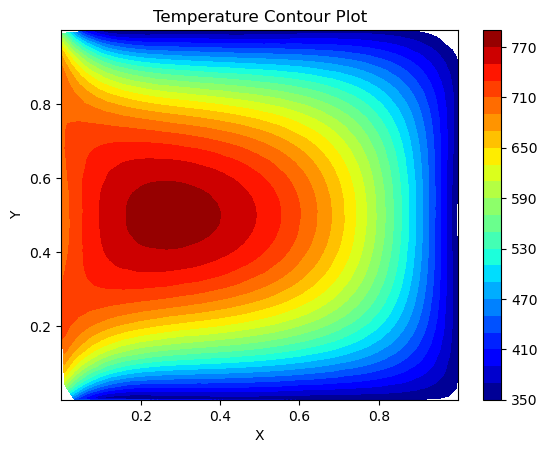

In [ ]:
from matplotlib.tri import Triangulation

# Create a Triangulation object
triang = Triangulation(X, Y)
# Define the minimum, maximum, and step size for contour levels
min_val = 350
max_val = 782
step = 20  # Specify the step size for contour levels

# Generate the contour levels using numpy
levels = np.arange(min_val, max_val + step, step)

# Plot the temperature contour with specified levels
plt.tricontourf(triang, Z, levels=levels, cmap='jet')
plt.colorbar()  # Add a color bar indicating the temperature values
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Temperature Contour Plot')
plt.show()

In [ ]:
Z

array([758.2871 , 434.98248, 428.8006 , ..., 511.49884, 432.16586,
       748.4015 ], dtype=float32)

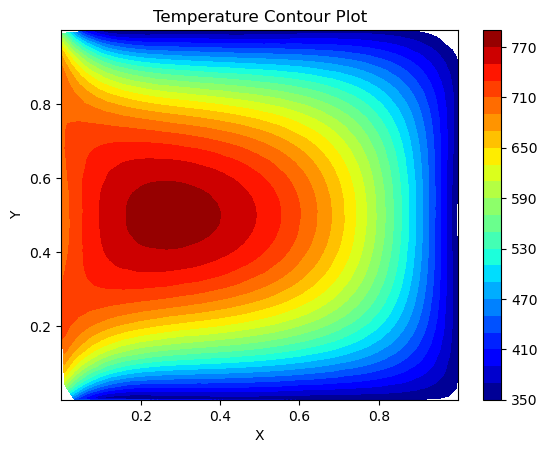

In [ ]:
from matplotlib.tri import Triangulation

# Create a Triangulation object
triang = Triangulation(X, Y)
# Define the minimum, maximum, and step size for contour levels
min_val = 350
max_val = 780
step = 20  # Specify the step size for contour levels

# Generate the contour levels using numpy
levels = np.arange(min_val, max_val + step, step)

# Plot the temperature contour with specified levels
plt.tricontourf(triang, Z, levels=levels, cmap='jet')
plt.colorbar()  # Add a color bar indicating the temperature values
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Temperature Contour Plot')
plt.show()

In [ ]:
print(Z.min(), Z.max())

331.8029 781.3322


max Temp: 782

In [ ]:
import pandas as pd
import numpy as np

# Assuming you have three NumPy arrays named array1, array2, and array3


# Create a Pandas DataFrame from the arrays
data = {
    'Values1': X,
    'Values2': Y,
    'Values3': Z
}
df = pd.DataFrame(data)

# Export DataFrame to an Excel file (adjust filename/path as needed)
excel_filename = "poisson_random.xlsx"
df.to_excel(excel_filename, index=False)

print(f"Arrays values have been exported to '{excel_filename}'")
